In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from pathlib import Path
#from torch import cdist
import os


In [2]:
from catboost import CatBoostClassifier
from hmmlearn import hmm
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
import math
# from statsmodels.tsa.arima.model import ARIMA

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
ROOT_DIR = Path().cwd()
while not ROOT_DIR.joinpath("data").exists():
    ROOT_DIR = ROOT_DIR.parent
os.chdir(ROOT_DIR)

In [5]:
from processors import processor_factory
from data.DatasetManager import DatasetManager

bpic2011_f1
bpic2011_f2
bpic2011_f3
bpic2011_f4


In [12]:
case_id_col = 'Case ID'
timestamp_col = 'time:timestamp'
target_col = "Activity"
dataset_name = 'bpic2011_f1'

In [13]:
df = pd.read_csv('data/processed_benchmark_event_logs/BPIC11_f1.csv', sep=';')
# df = pd.read_csv('data/processed_benchmark_event_logs/bpic2012_O_ACCEPTED-COMPLETE.csv', sep=';')

In [14]:
dataset_manager = DatasetManager(dataset_name)

In [15]:
df[dataset_manager.timestamp_col] = pd.to_datetime(df[dataset_manager.timestamp_col])

In [16]:
df.sort_values([dataset_manager.case_id_col, dataset_manager.timestamp_col], inplace=True)

In [17]:
df[dataset_manager.case_id_col].nunique()

1140

In [18]:
df

,Diagnosis,Treatment code,Diagnosis code,Specialism code,Diagnosis Treatment Combination ID,Age,Case ID,label,Activity code,Producer code,...,Number of executions,time:timestamp,timesincemidnight,month,weekday,hour,timesincelastevent,timesincecasestart,event_nr,open_cases
0,maligniteit cervix,TC103,M13,SC61,DTC376907,33,0,regular,AC410100,SRTH,...,1,2005-01-02 23:00:00,1380,1,6,23,0.0,0.0,1,5
1,maligniteit cervix,TC103,M13,SC61,DTC376907,33,0,regular,AC419100,SRTH,...,1,2005-01-02 23:00:00,1380,1,6,23,0.0,0.0,2,5
2,maligniteit cervix,TC103,M13,SC61,DTC376907,33,0,regular,AC10107,SGEH,...,1,2005-01-04 23:00:00,1380,1,1,23,0.0,2880.0,3,5
3,maligniteit cervix,TC103,M13,SC61,DTC376907,33,0,regular,339486E,SGEC,...,1,2005-01-04 23:00:00,1380,1,1,23,0.0,2880.0,4,5
4,maligniteit cervix,TC103,M13,SC61,DTC376907,33,0,regular,AC410100,SGEH,...,1,2005-01-04 23:00:00,1380,1,1,23,0.0,2880.0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67475,"Plaveiselcelca, cervix st Ib",missing,M13,SC7,DTC939743,52,1142,regular,377498A,CHE2,...,1,2008-03-19 23:00:00,1380,3,2,23,0.0,0.0,22,0
67476,"Plaveiselcelca, cervix st Ib",missing,M13,SC7,DTC939743,52,1142,regular,378453A,CHE2,...,1,2008-03-19 23:00:00,1380,3,2,23,0.0,0.0,23,0
67477,"Plaveiselcelca, cervix st Ib",missing,M13,SC7,DTC939743,52,1142,regular,AC378607,BLOB,...,1,2008-03-19 23:00:00,1380,3,2,23,0.0,0.0,24,0
67478,"Plaveiselcelca, cervix st Ib",missing,M13,SC7,DTC939743,52,1142,regular,379000A,HAEM,...,1,2008-03-19 23:00:00,1380,3,2,23,0.0,0.0,25,0


In [19]:
earliest_timestamps = df.groupby(dataset_manager.case_id_col)[dataset_manager.timestamp_col].min()


In [20]:
earliest_timestamps

Case ID
0      2005-01-02 23:00:00
1      2005-01-02 23:00:00
2      2005-01-02 23:00:00
3      2005-01-02 23:00:00
4      2005-01-02 23:00:00
               ...        
1138   2008-03-11 23:00:00
1139   2008-03-11 23:00:00
1140   2008-03-16 23:00:00
1141   2008-03-17 23:00:00
1142   2008-03-19 23:00:00
Name: time:timestamp, Length: 1140, dtype: datetime64[ns]

In [21]:
max_case_num = df[dataset_manager.case_id_col].nunique()

In [22]:
def get_first_n_cases(df, n):
    earliest_timestamps = df.groupby(dataset_manager.case_id_col)[dataset_manager.timestamp_col].min()
    sorted_cases = earliest_timestamps.sort_values().index[:n]
    return df[df[dataset_manager.case_id_col].isin(sorted_cases)]

In [23]:
filtered_df = get_first_n_cases(df, max_case_num)

In [24]:
# for col in [dataset_manager.activity_col]:
#         counts = filtered_df[col].value_counts()
#         mask = filtered_df[col].isin(counts[counts >= 500].index)
#         filtered_df.loc[~mask, col] = "other"

In [25]:
import seaborn as sns

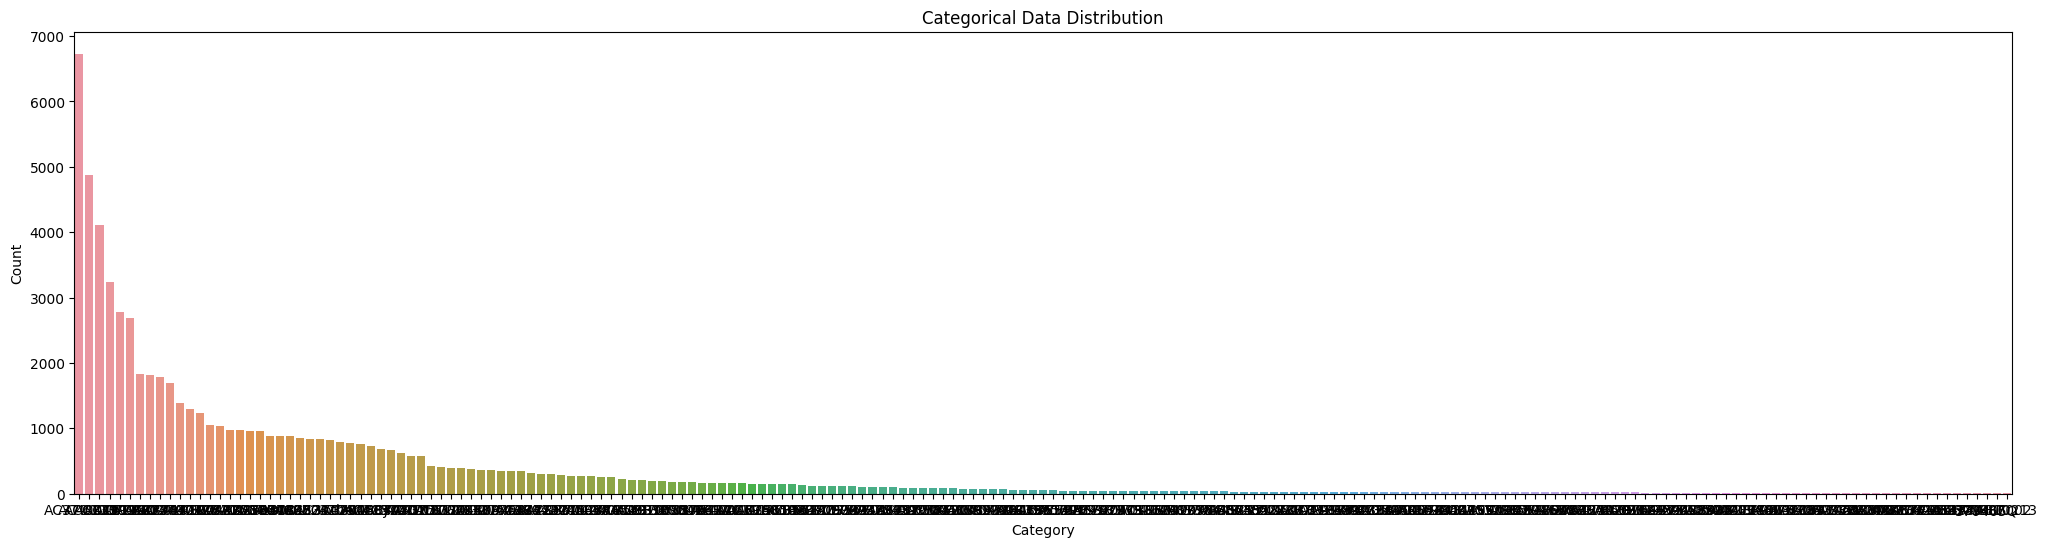

In [26]:
category_counts=filtered_df[dataset_manager.activity_col].value_counts()
# Count the occurrences of each category


# Plot using seaborn
plt.figure(figsize=(25, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Categorical Data Distribution')
plt.show()

In [27]:
results = []
method = 'LogisticRegression'
config = 'no_encoding_no_bucketing'
# config = 'no_encoding_bucketing'
# config = 'encoding_no_bucketing'
# config = 'encoding_bucketing'

In [28]:
# from data.dataset_confs import dataset_configs

# config = dataset_configs['CSL_5L']
use_encoding = False
use_bucketing = False
num_nearest_neighbors = 100
distance_metric = 'euclidean'

# processor = CSL_5LProcessor("5L", use_encoding, use_bucketing, num_nearest_neighbors, distance_metric)
processor = processor_factory.get_processor(dataset_name, use_encoding, use_bucketing, num_nearest_neighbors, distance_metric)

In [29]:
import time

In [30]:
min_prefix_length = 1
max_prefix_length = filtered_df['event_nr'].max()

In [ ]:
# import importlib
# #import DatasetManager
# import data.DatasetManager

# # Replace 'your_module_name' with the actual name of the file/module you want to reimport
# importlib.reload(data.DatasetManager)

In [32]:
start_test_prefix_generation = time.time()
print("Generating prefix data...")
dt_prefixes = dataset_manager.generate_prefix_data(filtered_df, min_prefix_length, max_prefix_length)
test_prefix_generation_time = time.time() - start_test_prefix_generation

Generating prefix data...
Activity code


In [27]:
dt_prefixes[dataset_manager.label_col].isnull().sum()

0

In [28]:
import data.EncoderFactory as EncoderFactory

In [29]:
encoder = EncoderFactory.get_encoder(method='agg', case_id_col=case_id_col, static_cat_cols=dataset_manager.static_cat_cols, static_num_cols=dataset_manager.static_num_cols, dynamic_cat_cols=dataset_manager.dynamic_cat_cols,
                dynamic_num_cols=dataset_manager.dynamic_num_cols, fillna=True, max_events=None, activity_col=dataset_manager.activity_col, resource_col=None, timestamp_col=timestamp_col,
                scale_model=None)

In [30]:
dt_transformed = encoder.transform(dt_prefixes)
dt_transformed.columns

Index(['Activity_A_ACCEPTED-COMPLETE', 'Activity_A_ACTIVATED-COMPLETE',
       'Activity_A_APPROVED-COMPLETE', 'Activity_A_CANCELLED-COMPLETE',
       'Activity_A_DECLINED-COMPLETE', 'Activity_A_FINALIZED-COMPLETE',
       'Activity_A_PARTLYSUBMITTED-COMPLETE',
       'Activity_A_PREACCEPTED-COMPLETE', 'Activity_A_REGISTERED-COMPLETE',
       'Activity_A_SUBMITTED-COMPLETE',
       ...
       'event_nr_mean', 'event_nr_max', 'event_nr_min', 'event_nr_sum',
       'event_nr_std', 'open_cases_mean', 'open_cases_max', 'open_cases_min',
       'open_cases_sum', 'open_cases_std'],
      dtype='object', length=139)

In [31]:
dt_transformed.reset_index(drop=False, inplace=False)[case_id_col]

0           173688
1           173691
2           173694
3           173715
4           173718
            ...   
186688    214361_5
186689    214361_6
186690    214361_7
186691    214361_8
186692    214361_9
Name: Case ID, Length: 186693, dtype: object

In [32]:
def return_last_row(group):
    max_event_row = group.loc[group['event_nr'].idxmax()]
    return max_event_row

In [34]:
subset = dt_prefixes[[dataset_manager.case_id_col, dataset_manager.timestamp_col, dataset_manager.activity_col, dataset_manager.label_col, 'event_nr', 'case_length'] + dataset_manager.static_num_cols+dataset_manager.static_cat_cols]
subset = subset.groupby(dataset_manager.case_id_col).apply(return_last_row).reset_index(drop=True)

In [35]:
# Create a new column 'finished' with values based on the condition
subset['finished'] = (subset['event_nr'] == subset['case_length']).astype(int)

# Display the updated DataFrame with the new 'finished' column
subset.head()


,Case ID,Complete Timestamp,Activity,label,event_nr,case_length,AMOUNT_REQ,finished
0,173688,2011-10-01 01:38:44.546,A_SUBMITTED-COMPLETE,deviant,1,26,20000,0
1,173691,2011-10-01 09:08:58.256,A_SUBMITTED-COMPLETE,deviant,1,39,5000,0
2,173694,2011-10-01 09:10:30.287,A_SUBMITTED-COMPLETE,deviant,1,59,7000,0
3,173715,2011-10-01 10:59:10.501,A_SUBMITTED-COMPLETE,regular,1,24,45000,0
4,173718,2011-10-01 11:37:39.363,A_SUBMITTED-COMPLETE,deviant,1,77,15000,0


In [36]:
merged_df = pd.merge(subset, dt_transformed, on=[dataset_manager.case_id_col])
merged_df

,Case ID,Complete Timestamp,Activity,label,event_nr,case_length,AMOUNT_REQ,finished,Activity_A_ACCEPTED-COMPLETE,Activity_A_ACTIVATED-COMPLETE,...,event_nr_mean,event_nr_max,event_nr_min,event_nr_sum,event_nr_std,open_cases_mean,open_cases_max,open_cases_min,open_cases_sum,open_cases_std
0,173688,2011-10-01 01:38:44.546,A_SUBMITTED-COMPLETE,deviant,1,26,20000,0,0,0,...,1.0,1,1,1,0.000000,1.000000,1,1,1,0.000000
1,173691,2011-10-01 09:08:58.256,A_SUBMITTED-COMPLETE,deviant,1,39,5000,0,0,0,...,1.0,1,1,1,0.000000,2.000000,2,2,2,0.000000
2,173694,2011-10-01 09:10:30.287,A_SUBMITTED-COMPLETE,deviant,1,59,7000,0,0,0,...,1.0,1,1,1,0.000000,3.000000,3,3,3,0.000000
3,173715,2011-10-01 10:59:10.501,A_SUBMITTED-COMPLETE,regular,1,24,45000,0,0,0,...,1.0,1,1,1,0.000000,8.000000,8,8,8,0.000000
4,173718,2011-10-01 11:37:39.363,A_SUBMITTED-COMPLETE,deviant,1,77,15000,0,0,0,...,1.0,1,1,1,0.000000,9.000000,9,9,9,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186688,214361_5,2012-03-01 16:20:31.425,W_Completeren aanvraag-START,regular,5,28,5000,0,0,0,...,3.0,5,1,15,1.581139,889.400000,900,847,4447,23.702321
186689,214361_6,2012-03-01 16:24:17.346,W_Completeren aanvraag-COMPLETE,regular,6,28,5000,0,0,0,...,3.5,6,1,21,1.870829,882.333333,900,847,5294,27.369082
186690,214361_7,2012-03-01 19:11:26.738,W_Completeren aanvraag-START,regular,7,28,5000,0,0,0,...,4.0,7,1,28,2.160247,874.142857,900,825,6119,33.072791
186691,214361_8,2012-03-01 19:24:29.805,A_ACCEPTED-COMPLETE,regular,8,28,5000,0,1,0,...,4.5,8,1,36,2.449490,868.000000,900,825,6944,35.205519


In [37]:
# Step 1: Identify object columns
object_columns = merged_df.select_dtypes(include=['object']).columns

# Step 2: Check if object columns contain boolean values
for col in object_columns:
    if merged_df[col].isin(['True', 'False', 'TRUE', 'FALSE', 'true', 'false']).all():
        merged_df[col] = merged_df[col].str.lower().map({'true': True, 'false': False})

        # Step 3: Transform boolean object columns to boolean data type
        merged_df[col] = merged_df[col].astype('boolean')

# Display the transformed DataFrame
merged_df.dtypes


Case ID                       object
Complete Timestamp    datetime64[ns]
Activity                      object
label                         object
event_nr                       int64
                           ...      
open_cases_mean              float64
open_cases_max                 int64
open_cases_min                 int64
open_cases_sum                 int64
open_cases_std               float64
Length: 147, dtype: object

In [38]:
merged_df[dataset_manager.activity_col].nunique()

36

In [ ]:
# merged_df.to_csv('data/sepsis_encoded.csv', sep=';', index=False)

In [39]:
def find_threshold(proba_values, true_values):
    list_acc = []
    thresholds = np.arange(0, 1.0, 0.05)
    true_values = true_values.map({'regular': True, 'deviant': False})


    for threshold in thresholds:
        preds_thr = proba_values > threshold
        acc= accuracy_score(true_values, preds_thr)
        # acc = np.mean(true_values == preds_thr)
        list_acc.append(acc)
        
        #print(f"Threshold: {threshold}, Accuracy: {acc}")

    # plt.plot(thresholds, list_acc)


    best_threshold = thresholds[np.where(list_acc==np.max(list_acc))]
    best_accuracy = np.max(list_acc)

    # print(f"Best Threshold: {best_threshold}, Best Accuracy: {best_accuracy}")
    return best_threshold, best_accuracy

In [108]:
# Define the values to experiment with
results = []
trainingtimes = []
AUCs = []
num_nearest_neighbors_values = [300]
distance_metrics = ['euclidean']
results_df = pd.DataFrame()

# Loop through the values and create processors
for num_nearest_neighbors in num_nearest_neighbors_values:
    for distance_metric in distance_metrics:
        print(f"Experimenting with num_nearest_neighbors={num_nearest_neighbors} and distance_metric={distance_metric}")
        
        # Create the processor with the current values
        processor = processor_factory.get_processor(dataset_name, use_encoding=False, use_bucketing=False, num_nearest_neighbors=num_nearest_neighbors, distance_metric=distance_metric)
        
    

        data = merged_df.sort_values([dataset_manager.case_id_col, dataset_manager.timestamp_col], ascending=True, kind='mergesort')
        # data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
        # data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
        # data['Target'] = data.groupby(dataset_manager.case_id_col)['Target'].ffill().bfill()
        # data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill()

        historic, current = processor.split_data_strict(data, train_ratio=0.5)
        historic.sort_values([dataset_manager.timestamp_col], ascending=True, kind='mergesort', inplace=True)
        current.sort_values([dataset_manager.timestamp_col], ascending=True, kind='mergesort', inplace=True)
        # current = current.head(1000)


        # Exclude specific columns from historic
        features_used = historic.columns.difference([dataset_manager.label_col, dataset_manager.timestamp_col, dataset_manager.case_id_col, 'event_nr', 'case_length', 'finished'], sort=False)
        # n_neighbors = 200
        # # Initialize the NearestNeighbors model
        # nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine")
        # # Fit the model on the historic data
        # nn_model.fit(historic[features_used])

        batch_size = 100

        initial_start_time = time.time()


        # num_model, cat_model = processor.train_nn_model_bpic_encoding(historic[features_used])
        nn_model = NearestNeighbors(n_neighbors=num_nearest_neighbors, metric=distance_metric)
        nn_model = make_pipeline(sklearn.preprocessing.StandardScaler(), nn_model)
        nn_model.fit(historic.drop(columns=[dataset_manager.label_col, dataset_manager.timestamp_col, dataset_manager.case_id_col, dataset_manager.activity_col]))

        initial_end_time = time.time()

        initial_training_time = initial_end_time - initial_start_time
        print("Initial Model Training time: ", initial_training_time, " seconds")

        for start in range(0, len(current), batch_size):
            end = start + batch_size
            batch = current.iloc[start:end]
            # Find the n nearest neighbors for the selected row
            #distances, indices = nn_model.kneighbors(batch.drop(columns=[dataset_manager.label_col, dataset_manager.timestamp_col, dataset_manager.case_id_col, dataset_manager.activity_col]).to_numpy())
            distances, indices = nn_model[1].kneighbors(batch.drop(columns=[dataset_manager.label_col, dataset_manager.timestamp_col, dataset_manager.case_id_col, dataset_manager.activity_col]).to_numpy())
            # distances, indices = processor.find_nearest_neighbors_encoding(cat_model, num_model, batch[features_used])
            nearest_neighbors = pd.concat([historic.iloc[indices[i]] for i in range(len(batch))])
            # nearest_neighbors = historic.iloc[indices.flatten()]

            # print(distances.shape)
            # print(indices.shape)

            # print(cat_model)
            # print(num_model)
            # print(features_used)
            # print(batch[features_used].shape)
            print(nearest_neighbors.shape)

            target = nearest_neighbors[dataset_manager.label_col].values
            target_test = batch[dataset_manager.label_col]

            # Split into training and calibration sets
            X_train, X_cal, y_train, y_cal = train_test_split(nearest_neighbors, target, test_size=0.3, random_state=42)

            if target_test is None:
                continue
            

            start_time = time.time()
            if method == 'Catboost':
                
                # categorical_features_indices = [nearest_neighbors.columns.get_loc(col) for col in processor.static_cat_cols+processor.dynamic_cat_cols]
                # Create the CatBoostRegressor model
                # model = CatBoostClassifier(iterations=100, loss_function='MultiClass', verbose=0, cat_features=processor.static_cat_cols + processor.dynamic_cat_cols) # , max_ctr_complexity=1
                model = CatBoostClassifier(iterations=1000, loss_function='Logloss', eval_metric='Accuracy', verbose=0, cat_features=[dataset_manager.activity_col]+dataset_manager.static_cat_cols)
                print('Now training')
                model.fit(X_train[features_used], y_train, cat_features=[dataset_manager.activity_col]+dataset_manager.static_cat_cols)

            if method == 'HMM':
                # Create an instance of the HMM model
                model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
                model.fit(nearest_neighbors[features_used])


            if method == 'LogisticRegression':
                from sklearn.preprocessing import OneHotEncoder
                from sklearn.pipeline import make_pipeline 
                #model = LogisticRegression()

                from sklearn.compose import make_column_selector, make_column_transformer

                preprocessor = make_column_transformer(
                    (OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include='object')),
                    remainder='passthrough'
                )
                model = make_pipeline(
                    preprocessor,
                    LogisticRegression()
                )
                model.fit(X_train[features_used], y_train)

            end_time = time.time()

            training_time = (end_time - start_time) / 60
            print("Training time: ", training_time, " minutes")
            trainingtimes.append(training_time)

            # Step 2: Wrap with calibration on held-out calibration data
            calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
            calibrated_model.fit(X_cal[features_used], y_cal)

            # Make predictions on the testing data
            print('Now predicting')
            preds = model.predict(batch[features_used])
            
            # probs = model.predict_proba(batch[features_used])[:, 1]
            # Step 3: Predict calibrated probabilities for the query instance
            probs = calibrated_model.predict_proba(batch[features_used])[:, 1]
            y_true = batch[dataset_manager.label_col].values
            # Check if y_true contains at least two classes
            if len(set(y_true)) > 1:
                auc = roc_auc_score(y_true, probs)
                AUCs.append(auc)
            else:
                print("Warning: Only one class present in y_true. Skipping ROC AUC calculation.")
                auc = None

            cal_probs = calibrated_model.predict_proba(X_cal[features_used])[:, 1]
            cal_true = X_cal[dataset_manager.label_col]
            best_threshold, best_accuracy = find_threshold(cal_probs, cal_true)
            preds_thr = probs > np.median(best_threshold)

            # Check if array has null values
            has_null = pd.Series(preds.flatten(), index=batch.index).isna().any()

            if has_null:
                print("Preds has null values")


            # true_conc_glu = row['Target_orig']
            # preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))

            batch.loc[:, 'predicted_value'] = pd.Series(preds.flatten(), index=batch.index)
            batch.loc[:, 'proba_of_regular'] = pd.Series(probs.flatten(), index=batch.index)
            batch.loc[:, 'predicted_thr'] = pd.Series(preds_thr.flatten(), index=batch.index)
            batch.loc[:, 'predicted_thr'] = batch['predicted_thr'].map({False: 'deviant', True: 'regular'})
            is_null = batch['predicted_value'].isna().any()
            if is_null:
                print("Batch has null values")

            results.append(batch)

            # Add the current row with its prediction to the historic data
            # row_with_prediction[target_col] = preds_scaled[0][0]
            finished_case_ids = batch[batch['finished'] == 1][case_id_col].unique()
            finished_cases = current[current[case_id_col].isin(finished_case_ids)]
            historic = pd.concat([historic, finished_cases], ignore_index=True)
            historic.sort_values([dataset_manager.case_id_col, dataset_manager.timestamp_col], ascending=True, kind='mergesort', inplace=True)
            # historic.drop(columns=['predicted_value', 'proba_of_regular'], inplace=True)
            # nn_model =processor.train_nn_model_bpic(historic)  # Refit the model with the updated historic data
            nn_model.fit(historic.drop(columns=[dataset_manager.label_col, dataset_manager.timestamp_col, dataset_manager.case_id_col, dataset_manager.activity_col]))
            # num_model, cat_model = processor.train_nn_model_bpic_encoding(historic[features_used])

        results_df = pd.concat(results)

        # Calculate metrics
        true_values = results_df[dataset_manager.label_col]
        predicted_values = results_df['predicted_value']
        proba_values = results_df['proba_of_regular']

        accuracy = np.mean(true_values == predicted_values)
        accuracy_thr = np.mean(true_values == results_df['predicted_thr'])
        
        # MAE_t = mean_absolute_error(true_values, predicted_values)
        # MSE_t = mean_squared_error(true_values, predicted_values)
        # RMSE_t = math.sqrt(MSE_t)
        # r2_t = r2_score(true_values, predicted_values)
        # mape_t = mean_absolute_percentage_error(true_values, predicted_values)

        # Save results to a CSV file
        # results_df.to_csv('predictions_with_row_data.csv', index=False)

        # Print metrics
        print(f"Accuracy: {accuracy}")
        print(f"Accuracy (Threshold): {accuracy_thr}")
        print(f"f1_score: {f1_score(true_values, predicted_values, average='weighted')}")
        print(f"Training Time: {sum(trainingtimes)/len(trainingtimes)}")
        print(f"AUC: {sum(AUCs)/len(AUCs)}")
        # print(f"MAE: {MAE_t}")
        # print(f"MSE: {MSE_t}")
        # print(f"RMSE: {RMSE_t}")
        # print(f"R2: {r2_t}")
        # print(f"MAPE: {mape_t}")

        output_dir = Path(f"results/{dataset_name}")
        output_dir.mkdir(parents=True, exist_ok=True)
        # dataset_name.mkdir(parents=True, exist_ok=True)
        results_df.to_csv(f'{output_dir}/BPIC2012_accepted_{method}_{config}_{num_nearest_neighbors}_{distance_metric}.csv', index=False)
        print('***********************************')


Experimenting with num_nearest_neighbors=300 and distance_metric=euclidean
Initial Model Training time:  0.0958709716796875  seconds
(30000, 147)
Training time:  0.010782329241434734  minutes
Now predicting
(30000, 147)
Training time:  0.013373732566833496  minutes
Now predicting
(30000, 147)
Training time:  0.012098884582519532  minutes
Now predicting
(30000, 147)
Training time:  0.015490182240804036  minutes
Now predicting
(30000, 147)
Training time:  0.008931879202524822  minutes
Now predicting
(30000, 147)
Training time:  0.017780200640360514  minutes
Now predicting
(30000, 147)
Training time:  0.01224279801050822  minutes
Now predicting
(30000, 147)
Training time:  0.012310155232747396  minutes
Now predicting
(30000, 147)
Training time:  0.00980985164642334  minutes
Now predicting
(30000, 147)
Training time:  0.01643243630727132  minutes
Now predicting
(30000, 147)
Training time:  0.012225250403086344  minutes
Now predicting
(30000, 147)
Training time:  0.00991446574529012  minute

In [92]:
nn_model[1].kneighbors

<bound method KNeighborsMixin.kneighbors of NearestNeighbors(metric='euclidean', n_neighbors=300)>

In [61]:
batch.shape

(100, 147)

In [59]:
model

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('logisticregression', LogisticRegression())])

In [57]:
model.predict(X_train[features_used])


array(['deviant', 'deviant', 'deviant', ..., 'deviant', 'deviant',
       'deviant'], dtype=object)

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve

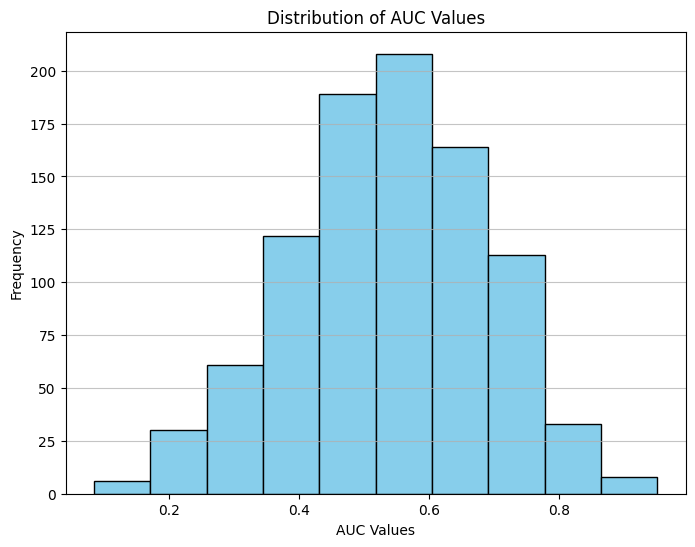

In [43]:
# Plotting the distribution
plt.figure(figsize=(8, 6))
plt.hist(AUCs, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('AUC Values')
plt.ylabel('Frequency')
plt.title('Distribution of AUC Values')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [ ]:
print(confusion_matrix(true_values, preds_thr))

In [ ]:
# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(true_values, proba_values)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
print(classification_report(true_values, preds_thr))

In [ ]:

accuracy_score(true_values, preds_thr)

In [ ]:
print(model.classes_)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [109]:
####### Baseline Version without JITL ########

# Define the values to experiment with

print(f"Experimenting with baseline version")

# Create the processor with the current values
processor = processor_factory.get_processor(dataset_name, use_encoding=False, use_bucketing=False, num_nearest_neighbors=num_nearest_neighbors, distance_metric=distance_metric)



data = merged_df.sort_values([dataset_manager.timestamp_col], ascending=True, kind='mergesort')
# data['Target'] = data.groupby(case_id_col)['Target'].ffill().bfill()

historic, current = processor.split_data_strict(data, train_ratio=0.5)
historic.sort_values([dataset_manager.timestamp_col], ascending=True, kind='mergesort', inplace=True)
current.sort_values([dataset_manager.timestamp_col], ascending=True, kind='mergesort', inplace=True)
# current = current.head(1000)


features_used = historic.columns.difference([dataset_manager.label_col, dataset_manager.timestamp_col, dataset_manager.case_id_col, 'case_length', 'event_nr', 'finished'])


# # Encode the target column
# label_encoder = LabelEncoder()
# historic[dataset_manager.label_col] = label_encoder.fit_transform(historic[dataset_manager.label_col])
# current[dataset_manager.label_col] = label_encoder.transform(current[dataset_manager.label_col])

# # Update the target variables
# target = historic[dataset_manager.label_col].values
# target_test = current[dataset_manager.label_col].values


target = historic[dataset_manager.label_col].values
target_test = current[dataset_manager.label_col]

start_time = time.time()
if method == 'Catboost':
        model = CatBoostClassifier(iterations=1000, loss_function='Logloss', eval_metric='AUC', verbose=0, cat_features=[dataset_manager.activity_col]+dataset_manager.static_cat_cols)
        print('Now training')
        model.fit(historic[features_used], target, cat_features=[dataset_manager.activity_col]+dataset_manager.static_cat_cols)

if method == 'HMM':
    # Create an instance of the HMM model
    model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
    model.fit(historic[features_used])
if method == 'LogisticRegression':
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.pipeline import make_pipeline 
    #model = LogisticRegression()

    from sklearn.compose import make_column_selector, make_column_transformer

    preprocessor = make_column_transformer(
        (OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include='object')),
        remainder='passthrough'
    )
    model = make_pipeline(
        preprocessor,
        LogisticRegression()
    )
    model.fit(X_train[features_used], y_train)

end_time = time.time()
training_time = (end_time - start_time) / 60
print("Training time: ", training_time, " minutes")
# trainingtimes.append(training_time)
batch_size = 100

print("Now predicting")
preds = model.predict(current[features_used])
probs = model.predict_proba(current[features_used])[:, 1]
y_true = current[dataset_manager.label_col].values
auc = roc_auc_score(y_true, probs)

results_baseline = current.copy()
results_baseline.loc[:, 'predicted_value'] = pd.Series(preds.flatten(), index=current.index)
results_baseline.loc[:, 'proba_of_regular'] = pd.Series(probs.flatten(), index=current.index)


# for start in range(0, len(current), batch_size):
#     end = start + batch_size
#     batch = current.iloc[start:end]

#     target = historic[dataset_manager.label_col].values
#     target_test = batch[dataset_manager.label_col]

#     if target_test is None:
#         continue

#     print('Now predicting')
#     # Make predictions on the testing data
#     preds = model.predict(batch[features_used])
#     probs = model.predict_proba(batch[features_used])[:, 1]
#     y_true = batch[dataset_manager.label_col].values
#     if len(set(y_true)) > 1:
#         auc = roc_auc_score(y_true, probs)
#         AUCs.append(auc)
#     else:
#         print("Warning: Only one class present in y_true. Skipping ROC AUC calculation.")
#         auc = None

#     # Check if array has null values
#     has_null = pd.Series(preds.flatten(), index=batch.index).isna().any()
#     if has_null:
#         print("Preds has null values")

#     batch.loc[:, 'predicted_value'] = pd.Series(preds.flatten(), index=batch.index)
#     is_null = batch['predicted_value'].isna().any()
#     if is_null:
#         print("Batch has null values")

#     results.append(batch)


# results_df = pd.concat(results)

# Calculate metrics
true_values = results_baseline[dataset_manager.label_col]
predicted_values = results_baseline['predicted_value']

accuracy = np.mean(true_values == predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"f1_score: {f1_score(true_values, predicted_values, average='weighted')}")
print(f"Training Time: {training_time}")
# print(f"AUC: {sum(AUCs)/len(AUCs)}")
print(f"AUC: {auc}")
# print(f"MAE: {MAE_t}")

results_baseline.to_csv(f'results/{dataset_name}/baseline_bpic2011_f1_{method}_{config}.csv', index=False)
print('***********************************')


Experimenting with baseline version
Training time:  0.004356765747070312  minutes
Now predicting
Accuracy: 0.47276291685860283
f1_score: 0.4689117378572791
Training Time: 0.004356765747070312
AUC: 0.5037157795458317
***********************************


In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_400['row_data'])

# Drop the original row_data column from results_df_baseline
tmp = results_df_400.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp = pd.concat([tmp, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp = tmp[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_300['row_data'])

# Drop the original row_data column from results_df_baseline
tmp2 = results_df_300.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp2 = pd.concat([tmp2, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp2 = tmp2[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_200['row_data'])

# Drop the original row_data column from results_df_baseline
tmp3 = results_df_200.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp3 = pd.concat([tmp3, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp3 = tmp3[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_100['row_data'])

# Drop the original row_data column from results_df_baseline
tmp4 = results_df_100.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp4 = pd.concat([tmp4, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp4 = tmp4[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [110]:
tmp = results_baseline.copy()
tmp.sort_values([dataset_manager.timestamp_col], ascending=True, kind='mergesort', inplace=True)

In [ ]:
results_baseline = tmp.copy()

In [111]:
tmp2 = results_df.copy()
tmp2.sort_values([dataset_manager.timestamp_col], ascending=True, kind='mergesort', inplace=True)

In [81]:
def calculate_moving_avg_mae(df, true_col, pred_col, window_size=5):
    true_values = df[true_col].to_numpy()
    predicted_values = df[pred_col].to_numpy()

    num_rows_list = []
    mae_list = []

    for i in range(2, len(true_values) + 1):
        num_rows_list.append(i)
        mae = f1_score(true_values[:i], predicted_values[:i], average='weighted')
        mae_list.append(mae)

    mae_df = pd.DataFrame({'num_rows': num_rows_list, 'mae': mae_list})
    mae_df['moving_avg_mae'] = mae_df['mae'].rolling(window=window_size).mean()
    
    return mae_df

In [82]:
def calculate_moving_avg_acc_fast(df, true_col, pred_col, window_size=5):
    # Convert columns to numpy arrays
    true_values = df[true_col].to_numpy()
    predicted_values = df[pred_col].to_numpy()

    # Calculate cumulative accuracy (vectorized)
    cumulative_correct = np.cumsum(true_values == predicted_values)
    num_rows = np.arange(1, len(true_values) + 1)
    cumulative_accuracy = cumulative_correct / num_rows

    # Create DataFrame for results
    mae_df = pd.DataFrame({
        'num_rows': num_rows[1:],  # Start from 2
        'mae': cumulative_accuracy[1:]  # Start from 2
    })

    # Calculate moving average of MAE
    mae_df['moving_avg_mae'] = mae_df['mae'].rolling(window=window_size).mean()

    return mae_df

In [112]:
# Calculate moving average MAE for tmp
mae_df_tmp = calculate_moving_avg_acc_fast(tmp, dataset_manager.label_col, 'predicted_value')

In [113]:
# Calculate moving average MAE for tmp2
mae_df_tmp2 = calculate_moving_avg_acc_fast(tmp2, dataset_manager.label_col, 'predicted_value')

# # Calculate moving average MAE for tmp2
# mae_df_tmp3 = calculate_moving_avg_mae(tmp3, 'true_value', 'predicted_value')

# # Calculate moving average MAE for tmp2
# mae_df_tmp4 = calculate_moving_avg_mae(tmp4, 'true_value', 'predicted_value')

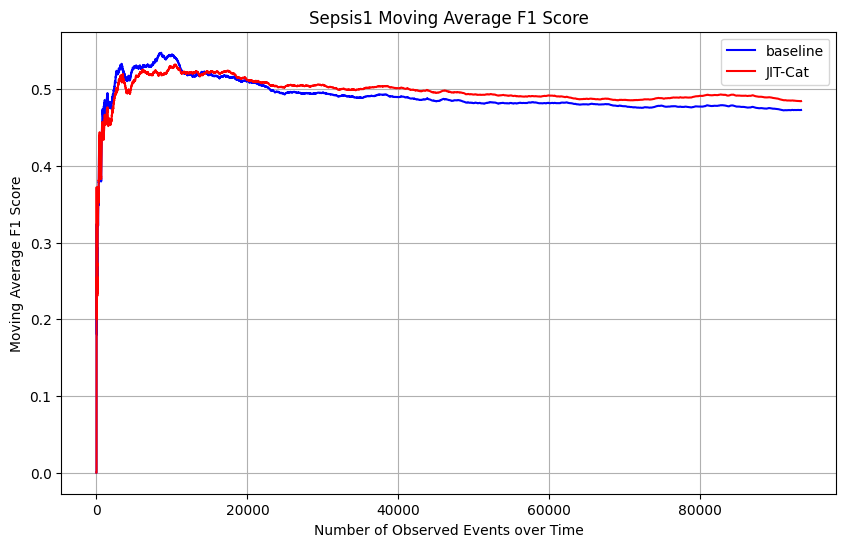

In [114]:


# Plot the moving average MAE for both DataFrames
plt.figure(figsize=(10, 6))
plt.plot(mae_df_tmp['num_rows'], mae_df_tmp['moving_avg_mae'], label='baseline', color='blue')
plt.plot(mae_df_tmp2['num_rows'], mae_df_tmp2['moving_avg_mae'], label='JIT-Cat', color='red')
# plt.plot(mae_df_tmp3['num_rows'], mae_df_tmp3['moving_avg_mae'], label='euclidean', color='green')
# plt.plot(mae_df_tmp4['num_rows'], mae_df_tmp4['moving_avg_mae'], label='DTW', color='black')
plt.xlabel('Number of Observed Events over Time')
plt.ylabel('Moving Average F1 Score')
plt.title('Sepsis1 Moving Average F1 Score')
plt.legend()
plt.grid(True)
plt.show()
# plt.savefig(f"results/{dataset_name}/moving_avg_f1_score.png", dpi=600, bbox_inches='tight')
# plt.close()

In [ ]:


# Plot the moving average accuracy for both DataFrames
plt.figure(figsize=(10, 6))
plt.plot(mae_df_tmp['num_rows'], mae_df_tmp['moving_avg_mae'], label='baseline', color='blue')
plt.plot(mae_df_tmp2['num_rows'], mae_df_tmp2['moving_avg_mae'], label='JIT-Cat', color='red')
# plt.plot(mae_df_tmp3['num_rows'], mae_df_tmp3['moving_avg_mae'], label='euclidean', color='green')
# plt.plot(mae_df_tmp4['num_rows'], mae_df_tmp4['moving_avg_mae'], label='DTW', color='black')
plt.xlabel('Number of Observed Events over Time')
plt.ylabel('Moving Average Accuracy')
plt.title('Sepsis1 Moving Average Accuracy')
plt.legend()
plt.grid(True)
# plt.show()
plt.savefig(f"results/{dataset_name}/moving_avg_accuracy_score.png", dpi=600, bbox_inches='tight')
plt.close()

In [ ]:
import os
import pandas as pd

def save_results_to_csv(dataset_name, proposed_metrics, baseline_metrics, file_path='results_metrics.csv'):
    """
    Save results metrics to a CSV file.

    Parameters:
        dataset_name (str): Name of the dataset.
        proposed_metrics (dict): Metrics for the proposed method (keys: accuracy, f1_score, auc, precision, recall).
        baseline_metrics (dict): Metrics for the baseline method (keys: accuracy, f1_score, auc, precision, recall).
        file_path (str): Path to the results CSV file.
    """
    # Define the columns for the CSV file
    columns = [
        'dataset_name',
        'proposed_accuracy', 'proposed_f1_score', 'proposed_auc', 'proposed_precision', 'proposed_recall',
        'baseline_accuracy', 'baseline_f1_score', 'baseline_auc', 'baseline_precision', 'baseline_recall'
    ]

    # Create a DataFrame for the new results
    new_data = {
        'dataset_name': dataset_name,
        'proposed_accuracy': proposed_metrics['accuracy'],
        'proposed_f1_score': proposed_metrics['f1_score'],
        'proposed_auc': proposed_metrics['auc'],
        'proposed_precision': proposed_metrics['precision'],
        'proposed_recall': proposed_metrics['recall'],
        'baseline_accuracy': baseline_metrics['accuracy'],
        'baseline_f1_score': baseline_metrics['f1_score'],
        'baseline_auc': baseline_metrics['auc'],
        'baseline_precision': baseline_metrics['precision'],
        'baseline_recall': baseline_metrics['recall']
    }

    new_row = pd.DataFrame([new_data])

    # Check if the file exists
    if not os.path.exists(file_path):
        # If the file doesn't exist, create it with the appropriate headers
        new_row.to_csv(file_path, index=False, columns=columns)
    else:
        # If the file exists, append the new row
        existing_data = pd.read_csv(file_path)
        # Check if the dataset already exists in the file
        if dataset_name in existing_data['dataset_name'].values:
            print(f"Dataset '{dataset_name}' already exists in the results file. Skipping.")
        else:
            new_row.to_csv(file_path, mode='a', index=False, header=False, columns=columns)

In [ ]:
def calculate_metrics(results_df):
    """
    Calculate metrics from a results DataFrame.

    Parameters:
        results_df (pd.DataFrame): DataFrame containing 'true_labels', 'predicted_labels', and 'predicted_probs'.

    Returns:
        dict: A dictionary containing accuracy, f1_score, auc, precision, and recall.
    """
    true_labels = results_df[dataset_manager.label_col]
    predicted_labels = results_df['predicted_value']
    predicted_probs = results_df['proba_of_regular']

    metrics = {
        'accuracy': accuracy_score(true_labels, predicted_labels),
        'f1_score': f1_score(true_labels, predicted_labels, average='weighted'),
        'auc': roc_auc_score(true_labels, predicted_probs),
        'precision': precision_score(true_labels, predicted_labels, average='weighted'),
        'recall': recall_score(true_labels, predicted_labels, average='weighted')
    }
    return metrics

In [ ]:
# Calculate metrics for proposed method
proposed_metrics = calculate_metrics(results_df)

# Calculate metrics for baseline method
baseline_metrics = calculate_metrics(results_baseline)

save_results_to_csv(f'{dataset_name}', proposed_metrics, baseline_metrics)

In [ ]:
df_results = pd.DataFrame(results).T
# HMM regular 
pd.options.display.float_format = '{:.2f}'.format
df_results[df_results.columns].mean()